In [1]:
import pandas as pd


df_wdc_co2 = pd.read_excel('data_for_plots.xlsx', sheet_name='WDC CO2', skiprows=1)
df_ngrip_d18o = pd.read_excel('data_for_plots.xlsx', sheet_name='NGRIP d18O', skiprows=1)
df_wdc_d18o = pd.read_excel('data_for_plots.xlsx', sheet_name='WDC d18O', skiprows=3)
df_do= pd.read_excel('data_for_plots.xlsx', sheet_name='DO', skiprows=1)
df_monsoon=pd.read_excel('data_for_plots.xlsx', sheet_name='monsoon', skiprows=1)
df_sealevel=pd.read_excel('data_for_plots.xlsx', sheet_name='sea level', skiprows=1)
df_ATS=pd.read_excel('data_for_plots.xlsx', sheet_name='ATS', skiprows=1)
df_composite_co2=pd.read_excel('data_for_plots.xlsx', sheet_name='composite CO2', skiprows=1)
df_LR04=pd.read_excel('data_for_plots.xlsx', sheet_name='LR04', skiprows=1)

# remove nan values for all three dataframes
df_wdc_co2 = df_wdc_co2.dropna()
df_ngrip_d18o = df_ngrip_d18o.dropna()
df_wdc_d18o = df_wdc_d18o.dropna()
df_monsoon=df_monsoon.dropna()
df_sealevel=df_sealevel.dropna()
df_ATS=df_ATS.dropna()
df_composite_co2=df_composite_co2.dropna()
df_LR04=df_LR04.dropna()


# rename columns to Age,Value
df_wdc_co2.columns = ['Age', 'Value', 'Error']
df_ngrip_d18o.columns = ['Age', 'Value']
df_wdc_d18o.columns = ['Age', 'Value']
df_monsoon.columns=['Age', 'Value']
df_sealevel.columns = ['Age', 'Value', 'Error']
df_ATS.columns=['Age', 'Value']
df_composite_co2.columns=['Age', 'Value', 'Error']
df_LR04.columns=['Age', 'Value','Error']


# drop values in the second column of df_wdc_d18o that above 999
df_wdc_d18o = df_wdc_d18o[df_wdc_d18o.iloc[:, 1] < 999]

# Age *-1
df_wdc_co2.Age = df_wdc_co2.Age * -1
df_ngrip_d18o.Age = df_ngrip_d18o.Age * -1
df_wdc_d18o.Age = df_wdc_d18o.Age * -1
df_monsoon.Age=df_monsoon.Age*-1000
df_sealevel.Age=df_sealevel.Age*-1000
df_ATS.Age=df_ATS.Age*-1
df_composite_co2.Age=df_composite_co2.Age*-1
df_LR04.Age=df_LR04.Age*-1000


# read the LGMR data
import xarray as xr
ds_LGMR_mean = xr.open_dataset('LGMR_GMST_climo.nc')
# ds_LGMR_mean.info
df_lgmr = ds_LGMR_mean.to_dataframe().reset_index()
# df_lgmr.head()  

# rename columns 
df_lgmr.columns = ['Age', 'Value', 'Error']
# *1
df_lgmr.Age = df_lgmr.Age * -1
df_lgmr

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


,Age,Value,Error
0,-100.0,13.488699,0.219001
1,-300.0,13.379682,0.192081
2,-500.0,13.367580,0.185994
3,-700.0,13.417512,0.169142
4,-900.0,13.521124,0.178768
...,...,...,...
115,-23100.0,7.095615,0.440728
116,-23300.0,7.171380,0.464787
117,-23500.0,7.177038,0.416002
118,-23700.0,7.250135,0.437566


In [122]:
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import column, row
from bokeh.models import CheckboxButtonGroup, CustomJS, HoverTool, ColumnDataSource, Div, Range1d, RangeSlider, TextInput, Button
from bokeh.io import curdoc
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from bokeh.models import Whisker
from bokeh.models import Band
from bokeh.models import Div

def interpolate_and_smooth(df, resolution=10, smooth_width=100):
    interp_func = interp1d(df.iloc[:, 0], df.iloc[:, 1], kind='linear', bounds_error=False)
    interpolated_ages = np.arange(df.iloc[:, 0].min(), df.iloc[:, 0].max() + resolution, resolution)
    interpolated_values = interp_func(interpolated_ages)
    window_size = smooth_width // resolution
    smoothed_values = np.convolve(interpolated_values, np.ones(window_size)/window_size, mode='valid')
    adjusted_ages = interpolated_ages[len(interpolated_ages) - len(smoothed_values):]
    return adjusted_ages, smoothed_values

# Interpolating and smoothing for δ18O data
wdc_d18o_ages, wdc_d18o_smoothed = interpolate_and_smooth(df_wdc_d18o)
ngrip_d18o_ages, ngrip_d18o_smoothed = interpolate_and_smooth(df_ngrip_d18o)

# Create a dictionary of data series
data_series = {
    "LGMR": df_lgmr,
    "WDC CO2": df_wdc_co2,
    "WDC δ18O": df_wdc_d18o,
    "NGRIP δ18O": df_ngrip_d18o,
    'Speleothem δ18O':df_monsoon,
    'Sea level': df_sealevel,
    'Antarctic Temperature Stack':df_ATS,
    'Composite CO2':df_composite_co2,
    'LR04':df_LR04

}
button_labels=['1. LGMR','2. WDC CO₂', '3. WDC δ¹⁸O', '4. NGRIP δ¹⁸O','5. Speleothem δ¹⁸O', '6. Sea level','7. Antarctic Temperature Stack','8. Composite CO₂','9. LR04 δ¹⁸O']

wdc_d18o_ages=wdc_d18o_ages/1000
ngrip_d18o_ages=ngrip_d18o_ages/1000

# Create Bokeh plot for each series
plots = []
xlabels=['Age (kyr relative to AD 1950)',
         'WD2014 Age (kyr, relative to AD 1950)', 
         'WD2014 Age (kyr, relative to AD 1950)', 
         'GICC05 Age (kyr, relative to AD 2000)',
         'Age (kyr relative to AD 1950)',
         'Age (kyr relative to AD 1950)',
         'Age (kyr relative to AD 1950)',
         'Age (kyr relative to AD 1950)',
         'Age (kyr relative to AD 1950)'
         ]
# ylabels=['CO2 (ppm)', 'δ18O (per mil)', 'δ18O (per mil)']
ylabels=['Global Mean Surface Temperature (°C)','CO₂ (ppm)', 'δ¹⁸O (permil)', 'δ¹⁸O (permil)','δ¹⁸O (permil)','Sea level (m)','Temperature (°C)','CO₂ (ppm)','δ¹⁸O (permil)']

y_ranges=[(5.3,14),(180, 290), (-44, -30), (-47, -32),(-3.7,-12.5),(-150,30),(-10,5),(170, 300),(5.3,2.5)]


y_range_middles=0.5*(np.array(y_ranges)[:,0]+np.array(y_ranges)[:,1])
y_hight=(np.array(y_ranges)[:,1]-np.array(y_ranges)[:,0])
DO_strips_dict = {}
DO_labels_dict = {}



for i, (name, df) in enumerate(data_series.items()):
    
    # if "DO" in name:
    #     continue

    source = ColumnDataSource(data=dict(x=df.iloc[:, 0]/1000, y=df.iloc[:, 1]))
    p = figure(sizing_mode='stretch_both', title=button_labels[i])

    p.y_range = Range1d(*y_ranges[i])
    
    # Plot GS
    x = df_do['middle of GS'].values*-1/1000
    y = y_range_middles[i]*np.ones(len(x))
    width = df_do['GS duration'].values/1000
    height = y_hight[i]*np.ones(len(x))

    DO_strips=p.rect(x, 
            y, 
            width, 
            height,
            fill_color="#ebdbb2",
            line_color="#ebdbb2"
            )# "#cab2d6"
    DO_strips.level = 'underlay' 
    DO_strips.visible = False
    DO_strips_dict[name] = DO_strips

    # add text annotation on the middle of GS, with 90 degree rotation
    # p.text(x=x+width/2, y=y, text=df_do['GS'].values, text_align='center', text_baseline='middle', text_font_size='8pt', angle=np.pi/2)
    DO_labels=p.text(x=df_do['middle of GS'].values*-1/1000, 
            y=(y_range_middles[i]+0.34*y_hight[i])*np.ones(len(x)),
            text=df_do['event'].values,
            text_font_size='8pt',
            text_align='center',
            text_baseline='middle',
            text_color='black',
            angle=np.pi/2
            
            )
    # set the order to be just above the strips
    DO_labels.level = 'glyph'
    DO_labels.visible = False
    DO_labels_dict[name] = DO_labels
    
    # plot the original data as a line plot
    p.line('x', 'y', source=source, line_width=2)

    # Check if 'Error' column exists and add error bands
    if 'Error' in df.columns:
        band_source = ColumnDataSource(data={
            'base': df.iloc[:, 0]/1000, 
            'lower': df.iloc[:, 1] - df['Error'], 
            'upper': df.iloc[:, 1] + df['Error']
        })

        band = Band(base='base', lower='lower', upper='upper', source=band_source, level='underlay',
                    fill_alpha=0.6, line_width=0, fill_color='gray')
        p.add_layout(band)
        
    p.visible = False
    p.xaxis.axis_label = xlabels[i]
    p.yaxis.axis_label = ylabels[i]
    p.x_range = Range1d(-70, -10)
    hover = HoverTool(tooltips=[("Time", "@x"), ("Value", "@y")])
    p.add_tools(hover)

    if "δ18O" in name:
        if "WDC" in name:
            smoothed_source = ColumnDataSource(data=dict(x=wdc_d18o_ages, y=wdc_d18o_smoothed))
            p.line('x', 'y', source=smoothed_source, line_width=2, color="red", legend_label="100 yr moving average")
            p.legend.location = "top_left"
        elif "NGRIP" in name:
            smoothed_source = ColumnDataSource(data=dict(x=ngrip_d18o_ages, y=ngrip_d18o_smoothed))
            p.line('x', 'y', source=smoothed_source, line_width=2, color="red", legend_label="100 yr moving average")
            # close legend
            p.legend.visible = False
            # p.legend.location = "top_left"

    plots.append(p)

# Set the CO2 plot to be visible initially
plots[0].visible = True
# plots[2].visible = True

# Create RangeSlider widget for x-axis range
x_range_slider = RangeSlider(start=-70, end=-10, value=(-70, -10), step=0.01, title="Age zoomer", direction='ltr', width=500)

# Create TextInput widgets for min and max data range
min_range_input = TextInput(value="-70", title="Age Range Oldest:")
max_range_input = TextInput(value="-10", title="Age Range Youngest:")

# Create a 'Set' Button
set_button = Button(label="Set", button_type="success", width=100, height=65)

# Callback for the 'Set' Button
set_button_callback = CustomJS(args=dict(min_range_input=min_range_input, max_range_input=max_range_input, x_range_slider=x_range_slider), code="""
    const min_range = parseFloat(min_range_input.value);
    const max_range = parseFloat(max_range_input.value);
    if (min_range < max_range) {
        x_range_slider.start = min_range;
        x_range_slider.end = max_range;
        x_range_slider.value = [min_range, max_range];
                               

        p.x_range.start = min_range;
        p.x_range.end = max_range;
                               
    } else {
        alert('Min range should be less than max range.');
    }
""")

set_button.js_on_click(set_button_callback)


set_button.js_on_click(set_button_callback)

# Callback for the RangeSlider
slider_callback = CustomJS(args=dict(plots=plots, x_range_slider=x_range_slider), code="""
    const start = x_range_slider.value[0];
    const end = x_range_slider.value[1];
    for (let p of plots) {
        p.x_range.start = start;
        p.x_range.end = end;
    }
""")
x_range_slider.js_on_change('value', slider_callback)


checkbox_buttons = CheckboxButtonGroup(labels=button_labels + ["10. Greenland Stadials"], active=[0], sizing_mode='scale_width')
checkbox_callback = CustomJS(args=dict(plots=plots, DO_strips_dict=DO_strips_dict, DO_labels_dict=DO_labels_dict, checkbox_buttons=checkbox_buttons), code="""
    for (let i = 0; i < plots.length; i++) {  // Exclude the last button which is for Greenland Stadials
        plots[i].visible = this.active.includes(i);
    }
    // Handle Greenland Stadials toggle separately
    let gsIndex = checkbox_buttons.labels.length-1;
    if (checkbox_buttons.active.includes(gsIndex)) {
        for (let key in DO_strips_dict) {
            DO_strips_dict[key].visible = true;
            DO_labels_dict[key].visible = true;
        }
    } else {
        for (let key in DO_strips_dict) {
            DO_strips_dict[key].visible = false;
            DO_labels_dict[key].visible = false;
        }
    }

""")

checkbox_buttons.js_on_change('active', checkbox_callback)



checkbox_buttons.js_on_change('active', checkbox_callback)

# Arrange layout
range_controls = row(min_range_input, max_range_input, set_button)


reference_text = Div(
    text="""<i>
    <br> Interactive Plots of Major Past Climate Records. Records are roughly sorted by their length and plotted on their original age scales. 
    For the WDC CO₂, Global sea level, the composite CO₂, And the LR04 data, the gray shaded areas indicate the ±1-sigma standard error.
    <br> <br> <br>
    <br> Data References:
    <br>1. 24 kyr Last Glacial Maximum Reanalysis (LGMR) Global Temperature Reconstructions, Osman et al., (2022), <a href="https://doi.org/10.1038/s41586-021-03984-4" target="_blank">DOI: 10.1038/s41586-021-03984-4</a>
    <br>2. 66 kyr WDC CO₂ data, Bauska et al., (2021), <a href="https://doi.org/10.1038/s41561-020-00680-2" target="_blank">DOI: 10.1038/s41561-020-00680-2</a>; 
    Marcott et al., (2014), <a href="https://doi.org/10.1038/nature13799" target="_blank">DOI: 10.1038/nature13799</a>
    <br>3. 66 kyr WDC δ¹⁸O data, WAIS, (2015), <a href="https://doi.org/10.1038/nature14401" target="_blank">DOI: 10.1038/nature14401</a>
    <br>4. 122 kyr NGRIP δ¹⁸O; Seierstad, et al. (2014), <a href="https://doi.org/10.1016/j.quascirev.2014.10.032" target="_blank">DOI: 10.1016/j.quascirev.2014.10.032</a>; 
    Rasmussen et al., (2014), <a href="https://doi.org/10.1016/j.quascirev.2014.09.007" target="_blank">DOI: 10.1016/j.quascirev.2014.09.007</a>
    <br>5. 640 kyr composite Chinese speleothem δ¹⁸O data, Cheng et al., (2016), <a href="https://doi.org/10.1038/nature18591" target="_blank">DOI: 10.1038/nature18591</a>
    <br>6. 798 kyr Global sea level data, Spratt & Lisiecki, <a href="https://doi.org/10.5194/cp-12-1079-2016" target="_blank">DOI: 10.5194/cp-12-1079-2016</a>
    <br>7. 800 kyr composite Antarctic temperature record, Parrenin et al., (2013) <a href="https://doi.org/10.1126/science.1226368" target="_blank">DOI: 10.1126/science.1226368</a>
    <br>8. 800 kyr composite CO₂ record, Bereiter et al., (2015), <a href="https://doi.org/10.1002/2014GL061957" target="_blank">DOI: 10.1002/2014GL061957</a>; Lüthi et al., (2008), <a href="https://doi.org/10.1038/nature06949" target="_blank">DOI: 10.1038/nature06949</a>
    <br>9. 5320 kyr LR04 benthic δ¹⁸O stack, Lisiecki & Raymo (2005), <a href="https://doi.org/10.1029/2004PA001071" target="_blank">DOI: 10.1029/2004PA001071</a>
    <br>10. Greenland Stadial timings are on the GICC05 timescale (relative to AD 2000), Rasmussen et al., (2014), <a href="https://doi.org/10.1016/j.quascirev.2014.09.007" target="_blank">DOI: 10.1016/j.quascirev.2014.09.007</a>
    <br> <br>Developed by P. Zheng<br> <br> <br>
    </i>""",
    width=1000, 
    height=80  # Increased height to accommodate multiple lines
)


# range_controls = row(min_range_input, max_range_input, set_button, align="end")
layout = column(checkbox_buttons, range_controls, x_range_slider, *plots, reference_text,sizing_mode='stretch_both')
# layout = column(checkbox_buttons, range_controls, x_range_slider, *plots, reference_text, js_div, sizing_mode='stretch_both')


curdoc().add_root(layout)

output_file("PastClimatePlots/index.html", title="PastClimatePlots")

show(layout)




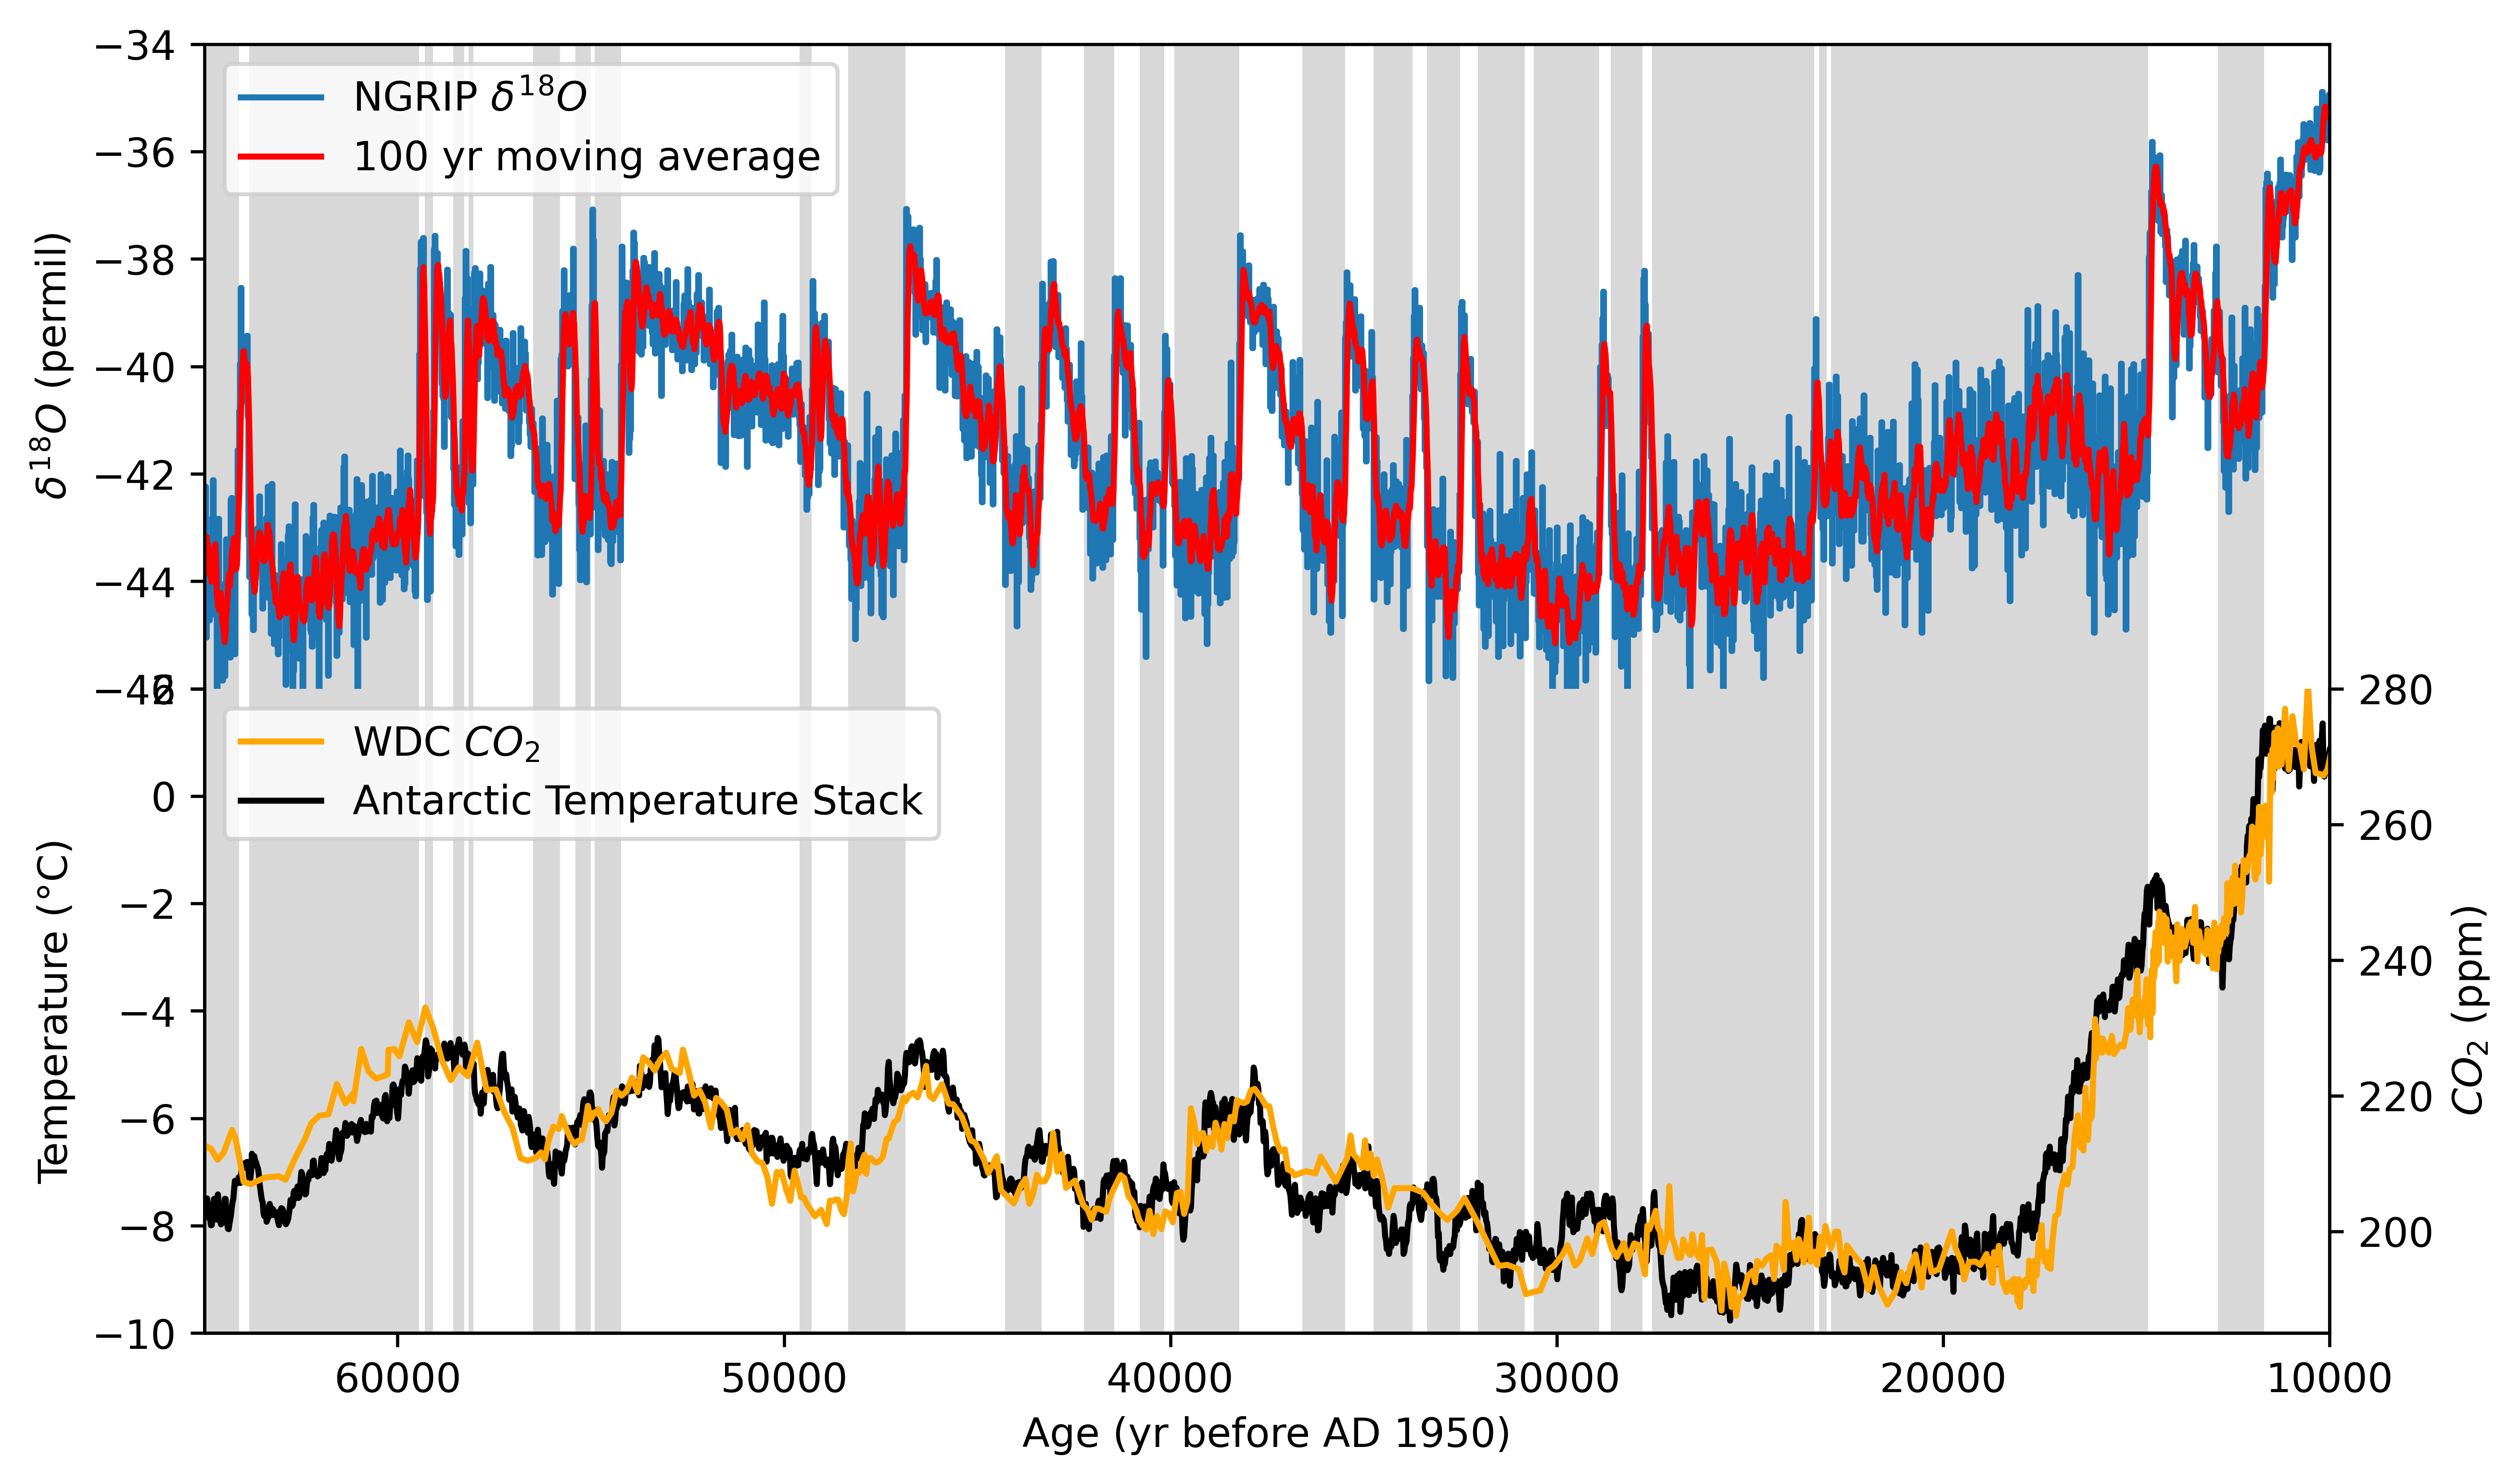

In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np


def interpolate_and_smooth(df, resolution=10, smooth_width=100):
    interp_func = interp1d(df.iloc[:, 0], df.iloc[:, 1], kind='linear', bounds_error=False)
    interpolated_ages = np.arange(df.iloc[:, 0].min(), df.iloc[:, 0].max() + resolution, resolution)
    interpolated_values = interp_func(interpolated_ages)
    window_size = smooth_width // resolution
    smoothed_values = np.convolve(interpolated_values, np.ones(window_size)/window_size, mode='valid')
    adjusted_ages = interpolated_ages[len(interpolated_ages) - len(smoothed_values):]
    return adjusted_ages, smoothed_values

# Interpolating and smoothing for δ18O data
ngrip_d18o_ages, ngrip_d18o_smoothed = interpolate_and_smooth(df_ngrip_d18o)

# Helper function to plot stadials
def plot_stadials(ax, df_stadials, y_min, y_max, color='gray', alpha=0.3):
    for _, row in df_stadials.iterrows():
        ax.axvspan(xmin=row['middle of GS'] - row['GS duration']/2,
                   xmax=row['middle of GS'] + row['GS duration']/2,
                   ymin=y_min, ymax=y_max, color=color, alpha=alpha, linewidth=0)

# Set up the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9.5, 5.8), sharex=True, dpi=600)

# Plot NGRIP δ18O
ax1.plot(df_ngrip_d18o['Age']*-1, df_ngrip_d18o['Value'], label='NGRIP $δ^1$$^8O$')
# plot the smoothed data
ax1.plot(ngrip_d18o_ages*-1, ngrip_d18o_smoothed, color='red', label='100 yr moving average')
plot_stadials(ax1, df_do, 0, 1, color='gray')
# ax1.set_title('NGRIP δ18O')
ax1.set_ylabel('$δ^1$$^8O$ (permil)')
ax1.legend(loc='upper left')
ax1.set_xlim(65000,10000)
# set y limit
ax1.set_ylim(-46, -34)
# set the bottom spine invisible
ax1.spines['bottom'].set_visible(False)
# set x label




# Plot ATS and Composite CO2 on the second subplot with twin axes
ax2_1 = ax2
ax2_2 = ax2.twinx()

ax2_1.plot(df_ATS['Age']*-1, df_ATS['Value'], label='Antarctic Temperature Stack', color='k')
# set y limit
ax2_1.set_ylim(-10,2)
# ax2_2.plot(df_composite_co2['Age']*-1, df_composite_co2['Value'], label='Composite $CO_2$', color='orange')
ax2_2.plot(df_wdc_co2['Age']*-1, df_wdc_co2['Value'], label='WDC $CO_2$', color='orange')
ax2_2.plot(0,0, label='Antarctic Temperature Stack', color='k')
# set y limit
ax2_2.set_ylim(185,280)

# Add stadials to the second subplot
plot_stadials(ax2_1, df_do, 0, 1, color='gray', alpha=0.3)
# plot_stadials(ax2_2, df_do, 0, 1, color='lightblue',alpha=0.3)  # Lighter for visibility

# ax2_1.set_title('ATS and Composite CO2')
ax2_1.set_ylabel('Temperature (°C)', color='k')
ax2_2.set_ylabel('$CO_2$ (ppm)', color='k')


# Legends
# ax2_1.legend(loc='upper left')
ax2_2.legend(loc='upper left')
# set x limit
ax2_1.set_xlim(65000, 10000)
# set the top spine invisible
ax2_1.spines['top'].set_visible(False)
ax2_2.spines['top'].set_visible(False)

ax2_1.set_xlabel('Age (yr before AD 1950)')


# Layout adjustments
plt.subplots_adjust(hspace=0)
plt.show()


In [84]:
# read in Chadwick et al-2022_Stacks_PCA_pc.csv
df_SO_seaice_pc1 = pd.read_csv('Chadwick et al-2022_Stacks_PCA_pc.csv')
# df_SO_seaice_pc1.columns = ['Age', 'Value']
df_SO_seaice_pc1

,Age (ka),PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,...,PC 21,PC 22,PC 23,PC 24,PC 25,PC 26,PC 27,PC 28,PC 29,PC 30
0,0,-0.29401,-0.48968,0.278380,0.010402,0.048838,-0.152340,0.292060,0.156030,0.064205,...,0.012162,-0.030371,-0.146010,0.134480,-0.130750,-0.049096,-0.018700,0.117500,-0.011128,0.064089
1,2,-0.43420,-0.59234,0.148520,-0.049662,-0.036112,-0.234220,0.076046,0.135650,0.037355,...,0.048641,-0.018255,0.004062,-0.101160,0.045269,0.065300,-0.038006,0.015486,0.030949,-0.008842
2,4,-0.68328,-0.59934,0.181890,-0.075996,-0.068759,-0.311510,-0.024778,-0.090487,-0.102230,...,0.054675,-0.075857,-0.083890,0.097164,0.044082,-0.006432,-0.037477,-0.061695,0.082748,-0.009006
3,6,-0.72987,-0.61841,0.102910,-0.098273,0.015317,-0.248200,-0.120010,-0.196370,-0.017791,...,0.078949,0.091805,-0.036143,-0.033262,0.018612,-0.057583,0.012910,0.025727,-0.012524,0.024925
4,8,-0.88427,-0.56660,0.099881,0.119350,0.136610,-0.359620,-0.001445,-0.073860,-0.189570,...,0.060819,0.016844,-0.068625,-0.009428,0.067340,-0.033902,-0.010488,-0.018750,-0.122230,-0.034144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,142,0.44771,-0.31676,0.048968,0.252030,0.216790,-0.021660,-0.179300,0.080473,0.183910,...,0.040774,0.041356,0.025992,0.002438,0.017624,0.029962,-0.032858,-0.041590,0.004029,0.015738
72,144,0.35947,-0.26006,0.010180,0.181740,0.002996,0.041846,-0.002326,-0.056892,0.296510,...,-0.075361,0.009637,-0.017540,0.010543,0.022312,-0.001797,0.012609,-0.005719,0.023600,-0.000573
73,146,0.35080,-0.25797,0.056758,0.243720,-0.095730,0.061309,0.022003,-0.139480,0.185790,...,-0.019189,-0.007135,-0.004714,-0.032159,0.014884,0.017810,-0.035272,-0.010409,0.009943,-0.005700
74,148,0.36769,-0.23985,0.062804,0.214370,-0.126890,-0.118040,0.026473,-0.170770,0.204600,...,-0.040735,-0.015042,0.027370,-0.046817,0.036537,0.016761,0.034631,-0.015496,0.001794,-0.005202


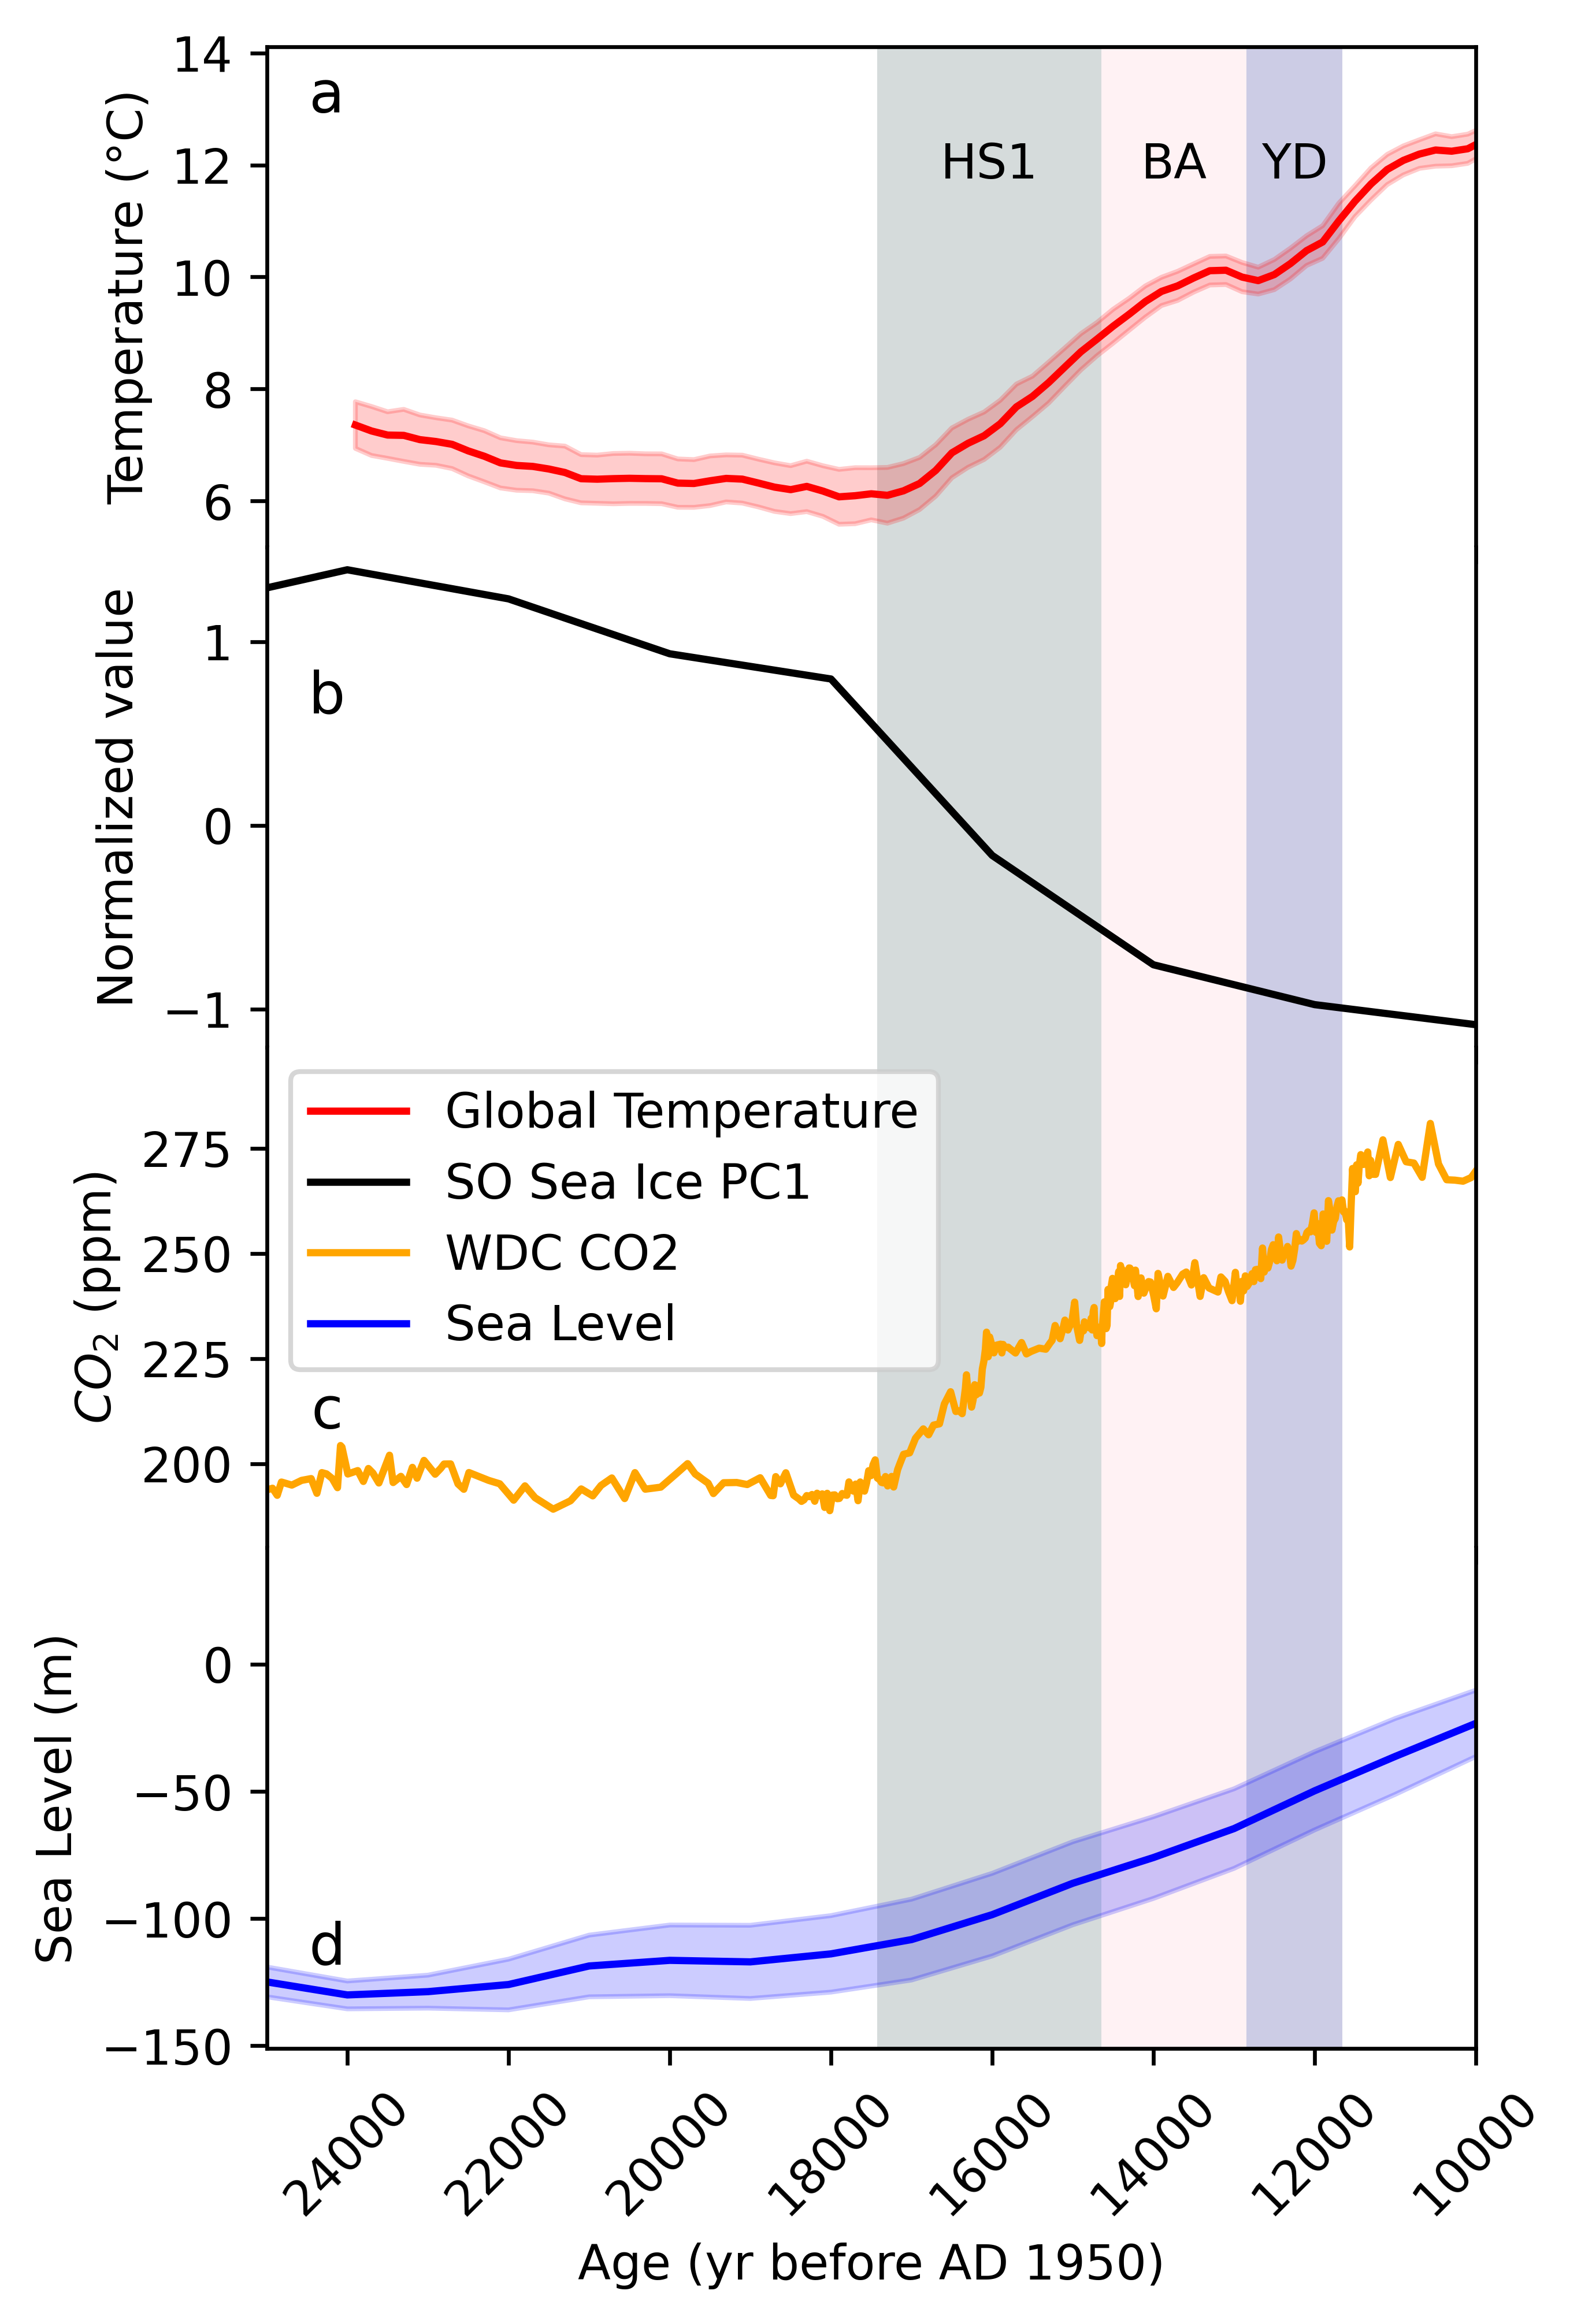

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(4.5, 7.5), sharex=True, dpi=600)

# Plot global temperature reconstruction in the first subplot with uncertainty
axes[0].plot(df_lgmr['Age']*-1, df_lgmr['Value'], label='Global Temperature Reconstruction', color='red')
axes[0].fill_between(df_lgmr['Age']*-1, df_lgmr['Value'] - df_lgmr['Error'], df_lgmr['Value'] + df_lgmr['Error'], color='red', alpha=0.2)
axes[0].set_ylabel('Temperature (°C)')

# Read in and plot data for the second subplot
df_SO_seaice_pc1 = pd.read_csv('Chadwick et al-2022_Stacks_PCA_pc.csv')
axes[1].plot(df_SO_seaice_pc1['Age (ka)']*1000, df_SO_seaice_pc1['PC 1'], label='SO Sea Ice PC1', color='k')
axes[1].set_ylabel('Normalized value')

# Plot WDC CO2 in the third subplot
axes[2].plot(0,0, label='Global Temperature', color='red')
axes[2].plot(0,0, label='SO Sea Ice PC1', color='k')
axes[2].plot(df_wdc_co2['Age']*-1, df_wdc_co2['Value'], label='WDC CO2', color='orange')
axes[2].plot(0,0, label='Sea Level', color='blue')

axes[2].set_ylabel('$CO_2$ (ppm)')
axes[2].set_ylim(180, 299)
axes[2].legend(loc='upper left')

# Plot sea level in the fourth subplot with uncertainty
# Plot sea level in the fourth subplot
axes[3].plot(0,0, label='Global Temperature', color='red')
axes[3].plot(0,0, label='SO Sea Ice PC1', color='k')
axes[3].plot(df_sealevel['Age']*-1, df_sealevel['Value'], label='Sea Level', color='blue')

axes[3].fill_between(df_sealevel['Age']*-1, df_sealevel['Value'] - df_sealevel['Error'], df_sealevel['Value'] + df_sealevel['Error'], color='blue', alpha=0.2)
axes[3].set_ylabel('Sea Level (m)')


# Set common x-axis properties
axes[3].set_xlim(25000, 10000)
plt.xticks(rotation=45)
axes[3].set_xlabel('Age (yr before AD 1950)')

# Modify spine visibility for the plot stack
for ax in axes[:-1]:
    ax.spines['bottom'].set_visible(False)
for ax in axes[1:]:
    ax.spines['top'].set_visible(False)

# Add historical period annotations
HS1 = np.array([17480, 14692]) - 50  # convert to b1950
BA = np.array([14692, 12896]) - 50
YD = np.array([12896, 11703]) - 50

def add_grey_bars(ax):
    ax.axvspan(HS1[1], HS1[0], color='darkslategray', alpha=0.2, lw=0, zorder=-1)
    ax.axvspan(BA[1], BA[0], color='pink', alpha=0.2, lw=0, zorder=-1)
    ax.axvspan(YD[1], YD[0], color='navy', alpha=0.2, lw=0, zorder=-1)

for ax in axes:
    add_grey_bars(ax)

axes[0].text(0.5*(HS1[0]+HS1[1]), 12, 'HS1', horizontalalignment='center', verticalalignment='center', fontsize=10, color='k')
axes[0].text(0.5*(BA[0]+BA[1]), 12, 'BA', horizontalalignment='center', verticalalignment='center', fontsize=10, color='k')
axes[0].text(0.5*(YD[0]+YD[1]), 12, 'YD', horizontalalignment='center', verticalalignment='center', fontsize=10, color='k')

# add a, b, c, d for each subplot
axes[0].text(0.05, 0.9, 'a', horizontalalignment='center', verticalalignment='center', fontsize=12, color='k', transform=axes[0].transAxes)
axes[1].text(0.05, 0.7, 'b', horizontalalignment='center', verticalalignment='center', fontsize=12, color='k', transform=axes[1].transAxes)
axes[2].text(0.05, 0.27, 'c', horizontalalignment='center', verticalalignment='center', fontsize=12, color='k', transform=axes[2].transAxes)
axes[3].text(0.05, 0.2, 'd', horizontalalignment='center', verticalalignment='center', fontsize=12, color='k', transform=axes[3].transAxes)

# Layout adjustments
plt.subplots_adjust(hspace=0)  # Adjust vertical spacing to prevent overlap
plt.show()


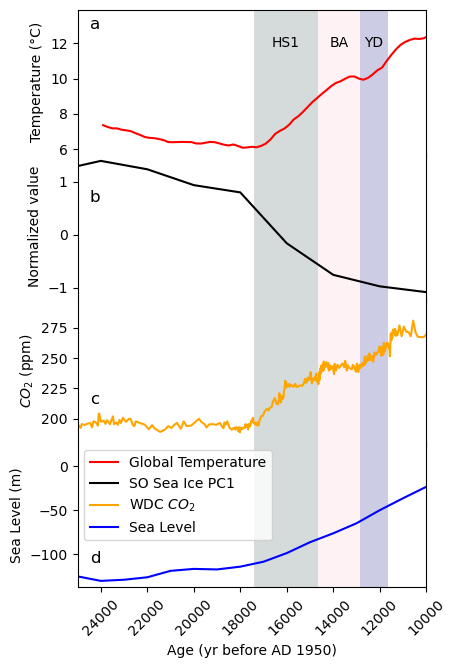

In [121]:
import matplotlib.pyplot as plt

# Set up the figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(4.5, 7.5), sharex=True, dpi=100)

# Plot global temperature reconstruction in the first subplot
axes[0].plot(df_lgmr['Age']*-1, df_lgmr['Value'], label='Global Temperature Reconstruction', color='red')
axes[0].set_ylabel('Temperature (°C)')
# axes[0].legend(loc='upper left')



# read in Chadwick et al-2022_Stacks_PCA_pc.csv
df_SO_seaice_pc1 = pd.read_csv('Chadwick et al-2022_Stacks_PCA_pc.csv')
# plot
axes[1].plot(df_SO_seaice_pc1['Age (ka)']*1000, df_SO_seaice_pc1['PC 1'], label='SO Sea Ice PC1', color='k')
# axes[1].text(0.5, 0.5, 'Data to be plotted', horizontalalignment='center', verticalalignment='center', fontsize=12, color='gray', transform=axes[1].transAxes)
axes[1].set_ylabel('Normalized value')

# Plot WDC CO2 in the third subplot
axes[2].plot(df_wdc_co2['Age']*-1, df_wdc_co2['Value'], label='WDC CO2', color='orange')
axes[2].set_ylabel('$CO_2$ (ppm)')
# axes[2].legend(loc='upper left')
axes[2].set_ylim(180, 299)  # Example limits, adjust based on your data

# Plot sea level in the fourth subplot
axes[3].plot(0,0, label='Global Temperature', color='red')
axes[3].plot(0,0, label='SO Sea Ice PC1', color='k')
axes[3].plot(0,0, label='WDC $CO_2$', color='orange')
axes[3].plot(df_sealevel['Age']*-1, df_sealevel['Value'], label='Sea Level', color='blue')


axes[3].set_ylabel('Sea Level (m)')
axes[3].legend(loc='upper left')
# axes[3].set_ylim(-130, 20)  

# Set x-axis limits and label
axes[3].set_xlim(25000, 10000)
# rotate x-axis labels
plt.xticks(rotation=45)
axes[3].set_xlabel('Age (yr before AD 1950)')

# from the first the the penultimate subplot, set the bottom spine invisible
for ax in axes[:-1]:
    ax.spines['bottom'].set_visible(False)

# from the second to the last subplot, set the top spine invisible
for ax in axes[1:]:
    ax.spines['top'].set_visible(False)


# Periods for the vertical grey bars
HS1 = np.array([17480, 14692]) - 50  # convert to b1950
BA = np.array([14692, 12896]) - 50
YD = np.array([12896, 11703]) - 50


# Function to add grey bars to the subplots
def add_grey_bars(ax):

    ax.axvspan(HS1[1], HS1[0], color='darkslategray', alpha=0.2, lw=0,zorder=-1)
    ax.axvspan(BA[1], BA[0], color='pink', alpha=0.2, lw=0,zorder=-1)
    ax.axvspan(YD[1], YD[0], color='navy', alpha=0.2, lw=0,zorder=-1)

# Add grey bars to all subplots
for ax in axes:
    add_grey_bars(ax)

# add text HS1, BA, YD for each grey bar
axes[0].text(0.5*(HS1[0]+HS1[1]), 12, 'HS1', horizontalalignment='center', verticalalignment='center', fontsize=10, color='k')
axes[0].text(0.5*(BA[0]+BA[1]), 12, 'BA', horizontalalignment='center', verticalalignment='center', fontsize=10, color='k')
axes[0].text(0.5*(YD[0]+YD[1]), 12, 'YD', horizontalalignment='center', verticalalignment='center', fontsize=10, color='k')

# add a, b, c, d for each subplot
axes[0].text(0.05, 0.9, 'a', horizontalalignment='center', verticalalignment='center', fontsize=12, color='k', transform=axes[0].transAxes)
axes[1].text(0.05, 0.7, 'b', horizontalalignment='center', verticalalignment='center', fontsize=12, color='k', transform=axes[1].transAxes)
axes[2].text(0.05, 0.3, 'c', horizontalalignment='center', verticalalignment='center', fontsize=12, color='k', transform=axes[2].transAxes)
axes[3].text(0.05, 0.2, 'd', horizontalalignment='center', verticalalignment='center', fontsize=12, color='k', transform=axes[3].transAxes)

# Layout adjustments
plt.subplots_adjust(hspace=0)  # Adjust vertical spacing to prevent overlap
plt.show()
